<a href="https://colab.research.google.com/github/shauryasachdev/Vizuara_CV/blob/main/Deep_NN_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

import os
PROJECT = "plated-shelter-464511-f9" # REPLACE WITH YOUR PROJECT ID
BUCKET = "bucket_ml_ss" # REPLACE WITH YOUR BUCKET NAME
REGION = "asia" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "2.19"  # Tensorflow version


In [2]:
import pathlib
from PIL import Image

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)
import tensorflow_hub as hub

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [5]:
from google.colab import drive
drive.mount('/content/drive')  # Mounts Drive at /content/drive/

# Set your desired Drive path (creates folder if it doesn't exist)
drive_path = '/content/drive/MyDrive/Colab Notebooks/flower_dataset/'

# Download and extract directly to the Drive path
archive = tf.keras.utils.get_file(
    'flower_photos.tgz',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    cache_dir=drive_path,  # Saves here instead of local cache
    extract=True
)

# Your exact path as Path object
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Verify
image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")  # Should be 3670

CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.is_dir()]
)
print("These are the available classes:", CLASS_NAMES)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 3670 images.
These are the available classes: ['dandelion' 'daisy' 'tulips' 'roses' 'sunflowers']


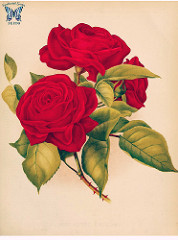

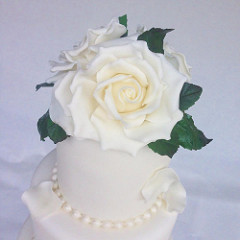

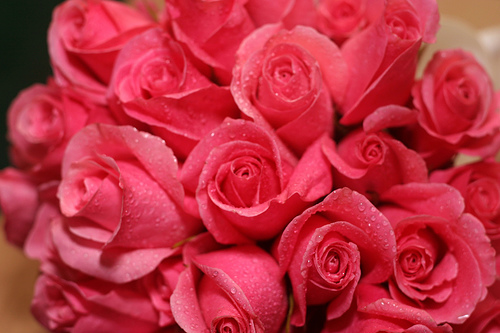

In [6]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [7]:
import random
import glob

# Your Drive path to the flower_photos folder with class subdirs
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Collect all image paths and labels from Drive (local paths)
all_images = []
for class_name in CLASS_NAMES:
    class_dir = data_dir / class_name
    images = glob.glob(str(class_dir / '*.jpg'))
    for img in images:
        all_images.append(f"{img},{class_name}")

# Shuffle and split into train/eval (80/20)
random.shuffle(all_images)
num_total = len(all_images)
num_train = int(0.8 * num_total)
train_lines = all_images[:num_train]
eval_lines = all_images[num_train:]

# Write CSVs to Drive (using data_dir as base)
train_csv_path = os.path.join(str(data_dir), 'train_set.csv')
eval_csv_path = os.path.join(str(data_dir), 'eval_set.csv')

with open(train_csv_path, 'w') as f:
    f.write('\n'.join(train_lines))
with open(eval_csv_path, 'w') as f:
    f.write('\n'.join(eval_lines))

# Verify: Print first 5 lines of train CSV using shell (with quoted path to avoid syntax errors)
!head -5 "{train_csv_path}"

/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/tulips/4562423077_00b16240dc_n.jpg,tulips
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/dandelion/3856725141_0db85f466d_n.jpg,dandelion
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/roses/2392457180_f02dab5c65.jpg,roses
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/dandelion/477207005_6327db8393_m.jpg,dandelion
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/roses/15822837396_96b392fda8_m.jpg,roses


In [8]:
Img_Height = 224
Img_Width = 224
Img_Channels = 3

Batch_Size = 32

def read_and_decode(filename, resize_dims):
  # Read the raw file
  img_bytes = tf.io.read_file(filename)
  # Decode the image data
  img = tf.image.decode_jpeg(img_bytes, channels=Img_Channels)
  # Convert the pixel values to float in [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to desired dimensions
  img = tf.image.resize(img, resize_dims)
  return img

In [9]:
def parse_csvline(csv_line):
  # record_defaults specify the data types for each column
  record_default = ["", ""]
  filename, label_string = tf.io.decode_csv(csv_line, record_default)

  # Load the image
  img = read_and_decode(filename, [Img_Height, Img_Width])

  # Conver label string to integer based on the Class_Names index
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [10]:
train_dataset = (
    tf.data.TextLineDataset(train_csv_path)
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
    tf.data.TextLineDataset(eval_csv_path)
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
# Test iteration
for image_batch, label_batch in train_dataset.take(1):
    print("Image Batch Shape:", image_batch.shape)
    print("Label Batch Shape:", label_batch.shape)
    print("Labels:", label_batch.numpy())

Image Batch Shape: (16, 224, 224, 3)
Label Batch Shape: (16,)
Labels: [2 0 3 0 3 3 0 0 4 4 1 0 4 4 0 0]


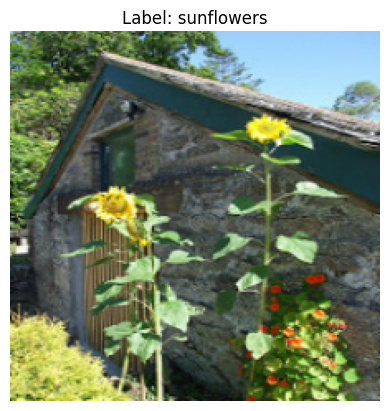

In [12]:
for image_batch, label_batch in eval_dataset.take(1):
  first_image = image_batch[0]
  first_label = label_batch[0]

  # convert tensor to numpy array
  plt.imshow(first_image.numpy())
  plt.title(f"Label: {CLASS_NAMES[first_label]}")
  plt.axis('off')
  plt.show()

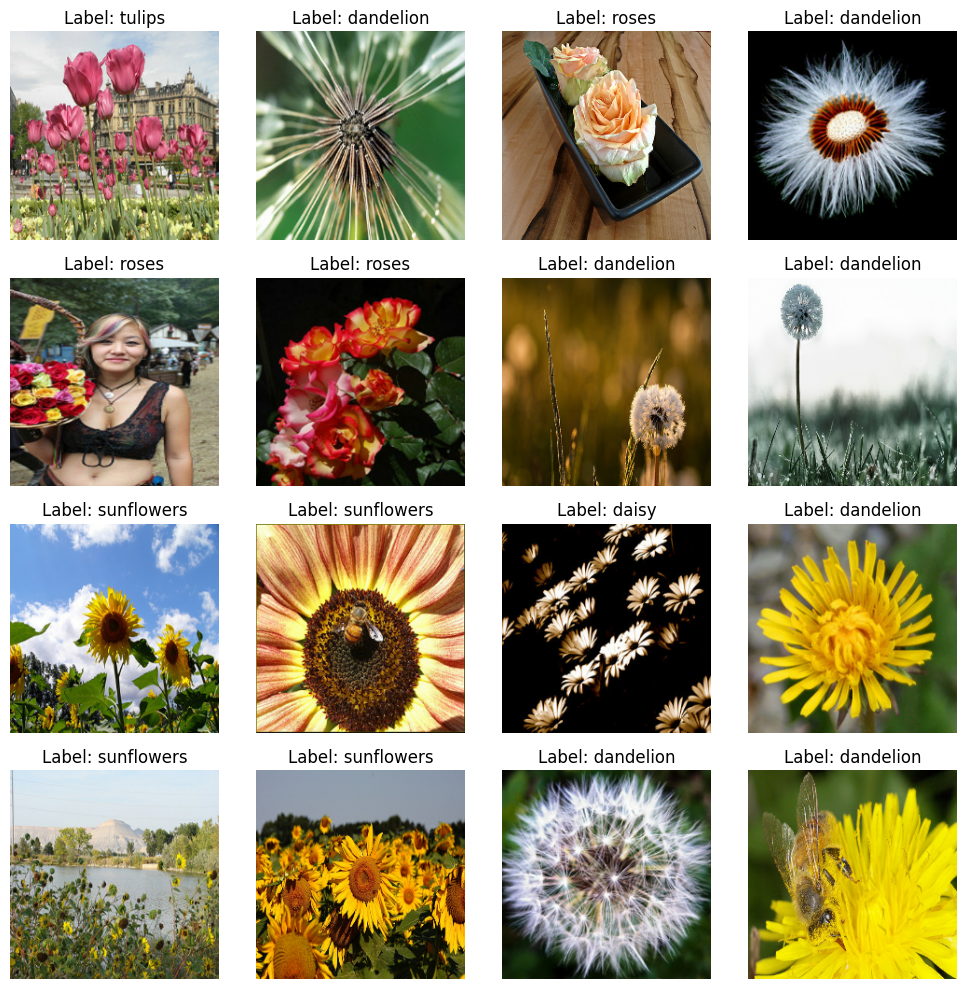

In [13]:
for image_batch, label_batch in train_dataset.take(1):
  fig, axes = plt.subplots(4,4, figsize=(10,10))

  for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(image_batch[i].numpy())
    ax.set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(Img_Height, Img_Width, Img_Channels)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation = 'softmax')
])

# In the earlier Linear Neural Network Model, we had (not accounting biases):
# layer 1 [nodes] = 224 * 224 * 3 = 150,528
# Ouput Layer [nodes] = 5
# Trainable Parameters = 150528 *5 = 752,640

# In this new Deep Neural Network Model, we have (accounting for biases):

# Input features [nodes] = 224 * 224 * 3 = 150,528

# Dense Layer [nodes] = 128

# Dense Layer Parameters with [weights] = 128 * input features = 128 * 150,528
# Dense Layer Parameters with [biases] = 128 + 150,528 * 128

# Ouput Layer  [nodes] = 5

# Output Layer Parameters [Weights] = 128 * 5
# Output Layer Parameters with [biases] = 128 + 5

# Trainable Parameters = (128 + 150,528 * 128) + (5 + 128 * 5) = 19,268,357

# Y = softmax(B1 + W2*(B1 + W1*X))
# Y = softmax(B2 + W2*B1 + W2*W1*X) = (B2 + W3*X) => Single Hidden Layer in effect which is linear
# New Neural Network is the same as the Old Linear Neural Network

# Let's add activation function
# sigma2=softmax(B1 + W2 * sigma1(B1 + W1*X)) => sigma1(B1 + W1*X) is not sigma1*(B1 + W1*X), it is sigma1 function of (B1 + W1*X)

model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,357 (73.50 MB)

 Trainable params: 19,268,357 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
EPOCHS = 5

histor = model.fit(
    train_dataset,
    validation_data = eval_dataset,
    epochs = EPOCHS
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


    184/Unknown 80s 414ms/step - accuracy: 0.3132 - loss: 32.0110

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


184/184 ━━━━━━━━━━━━━━━━━━━━ 85s 438ms/step - accuracy: 0.3133 - loss: 31.9301 - val_accuracy: 0.3556 - val_loss: 7.6948
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 80s 435ms/step - accuracy: 0.3981 - loss: 9.6161 - val_accuracy: 0.4046 - val_loss: 5.7687
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 81s 438ms/step - accuracy: 0.4452 - loss: 4.8663 - val_accuracy: 0.4237 - val_loss: 3.5258
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 101s 548ms/step - accuracy: 0.5302 - loss: 2.6397 - val_accuracy: 0.3992 - val_loss: 2.9718
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 80s 434ms/step - accuracy: 0.5472 - loss: 2.2452 - val_accuracy: 0.4019 - val_loss: 4.3364


<function matplotlib.pyplot.show(close=None, block=None)>

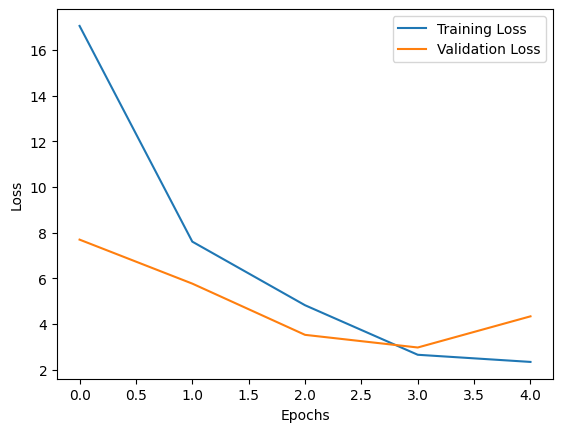

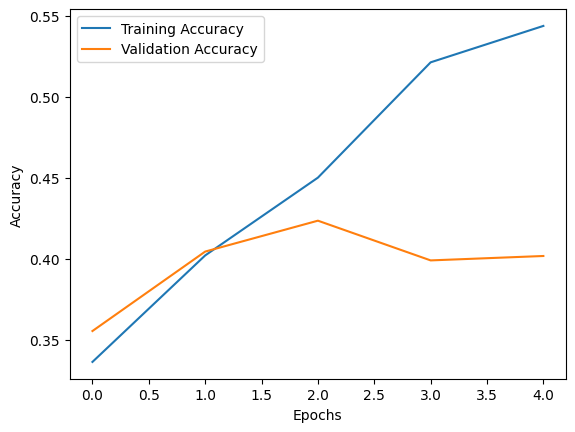

In [24]:
plt.figure()
plt.plot(histor.history["loss"], label="Training Loss")
plt.plot(histor.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

plt.figure()
plt.plot(histor.history["accuracy"], label="Training Accuracy")
plt.plot(histor.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


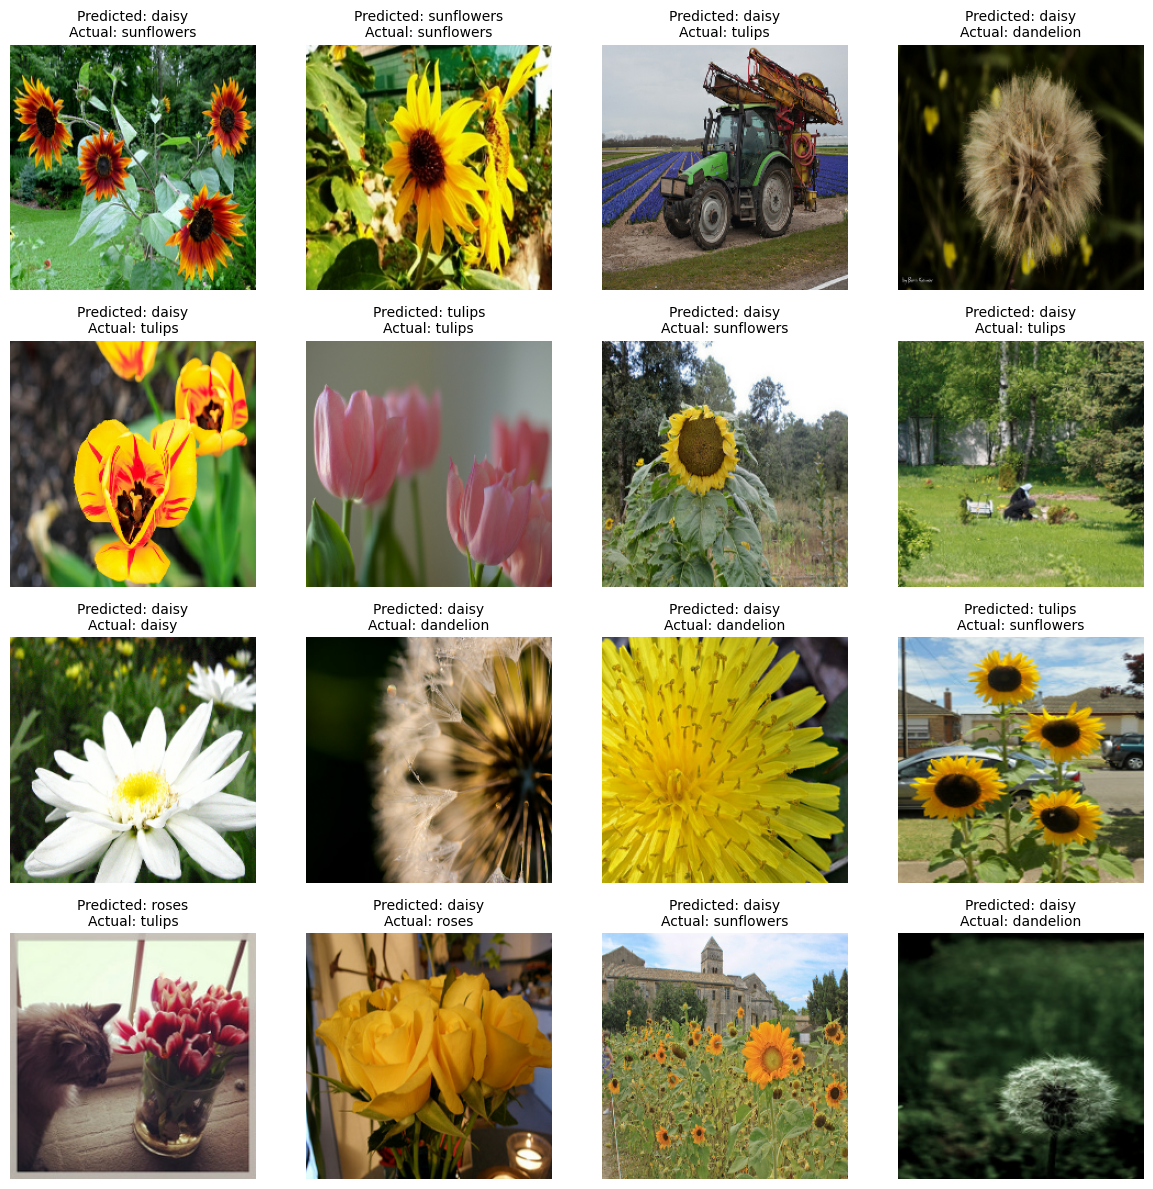

In [ ]:
import math

for images, labels in eval_dataset.take(1):
  batch_predictions = model.predict(images)
  predicted_indices = np.argmax(batch_predictions, axis = 1)

  num_images = images.shape[0]
  num_cols = 4
  num_rows = math.ceil(num_images / num_cols)

  plt.figure(figsize=(12,3*num_rows))

  for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")

    pred_class = CLASS_NAMES[predicted_indices[i]]
    actual_class = CLASS_NAMES[labels[i].numpy()]

    plt.title(f"Predicted: {pred_class}\nActual: {actual_class}", fontsize = 10)

  plt.tight_layout()
  plt.show